<a href="https://colab.research.google.com/github/MartinNde/MartinN_1/blob/main/Time_Series_Competition_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import the packages#

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import statsmodels.api as sm
import itertools
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.spatial.distance import cdist
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()


#Importing the Data#

In [128]:
raw_csv_data = pd.read_csv('/content/PT_Train.csv')

In [129]:
df = raw_csv_data.copy()

###view the data to have an understanding of the structure###

In [130]:
df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


###Attempt to view the entire data to see if something strange stands out.###

In [131]:
df

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0
...,...,...,...,...,...
221,17/08/2015 18:50,159,51,NaN,NaN
222,17/08/2015 18:51,151,64,NaN,NaN
223,17/08/2015 18:52,140,64,NaN,NaN
224,17/08/2015 18:53,140,55,NaN,NaN


In [132]:
print(df.shape)
df.head()

(226, 5)


,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


In [133]:
df.describe()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
count,226.000000,226.000000,191.000000,191.000000
mean,2315.615044,2219.216814,83.450262,126.335079
std,11351.588825,11370.093548,29.802974,46.348142
min,106.000000,34.000000,-1.000000,-1.000000
25%,136.000000,38.000000,92.000000,134.000000
50%,145.000000,46.000000,93.000000,139.000000
75%,156.000000,53.000000,95.000000,149.000000
max,61442.000000,61442.000000,98.000000,166.000000


In [134]:
df.isna().sum()

Timestamp (GMT)                0
Lifetouch Heart Rate           0
Lifetouch Respiration Rate     0
Oximeter SpO2                 35
Oximeter Pulse                35
dtype: int64

Simpliyfing the Dataset by taking out the columns that are not needed for the prediction.

In [135]:
df = df.drop(['Lifetouch Respiration Rate','Oximeter SpO2','Oximeter Pulse'], axis=1)



In [136]:
df.describe()

,Lifetouch Heart Rate
count,226.000000
mean,2315.615044
std,11351.588825
min,106.000000
25%,136.000000
50%,145.000000
75%,156.000000
max,61442.000000


In [137]:
df.isna().sum()

Timestamp (GMT)         0
Lifetouch Heart Rate    0
dtype: int64

Setting the index

In [138]:
df['Timestamp (GMT)']=pd.to_datetime(df['Timestamp (GMT)'])

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Timestamp (GMT)       226 non-null    datetime64[ns]
 1   Lifetouch Heart Rate  226 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.7 KB


In [140]:
df.set_index("Timestamp (GMT)", inplace = True)

In [141]:
df

,Lifetouch Heart Rate
Timestamp (GMT),
2015-08-17 15:09:00,139
2015-08-17 15:10:00,144
2015-08-17 15:11:00,140
2015-08-17 15:12:00,138
2015-08-17 15:13:00,133
...,...
2015-08-17 18:50:00,159
2015-08-17 18:51:00,151
2015-08-17 18:52:00,140


In [142]:
df.sort_values(by=['Lifetouch Heart Rate']).tail(20)

,Lifetouch Heart Rate
Timestamp (GMT),
2015-08-17 17:54:00,163
2015-08-17 17:55:00,164
2015-08-17 17:40:00,164
2015-08-17 18:07:00,164
2015-08-17 18:01:00,165
2015-08-17 17:56:00,166
2015-08-17 17:39:00,166
2015-08-17 17:42:00,167
2015-08-17 17:58:00,169


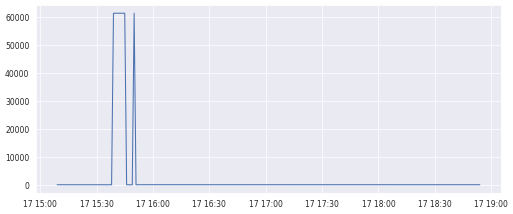

In [143]:
plt.figure(figsize =(12,5),dpi=50)
plt.plot(df)
plt.show()

Dealing with outliers

# New section

In [144]:
df = df.replace({'Lifetouch Heart Rate':{61441:np.nan,61442:np.nan}})

In [145]:
df.sort_values(by=['Lifetouch Heart Rate']).tail(20)

,Lifetouch Heart Rate
Timestamp (GMT),
2015-08-17 17:33:00,163.0
2015-08-17 17:55:00,164.0
2015-08-17 17:40:00,164.0
2015-08-17 18:07:00,164.0
2015-08-17 18:01:00,165.0
2015-08-17 17:56:00,166.0
2015-08-17 17:39:00,166.0
2015-08-17 17:42:00,167.0
2015-08-17 17:57:00,169.0


In [146]:
df = df.ffill()

In [147]:
df.sort_values(by=['Lifetouch Heart Rate']).tail(20)

,Lifetouch Heart Rate
Timestamp (GMT),
2015-08-17 18:05:00,161.0
2015-08-17 17:32:00,162.0
2015-08-17 17:31:00,162.0
2015-08-17 17:30:00,163.0
2015-08-17 17:34:00,163.0
2015-08-17 17:54:00,163.0
2015-08-17 17:52:00,163.0
2015-08-17 18:02:00,163.0
2015-08-17 17:33:00,163.0


Splitting Data - An 80/20 split is reasonable

In [148]:
df_train = df.iloc[0:80]

In [149]:
df_train.shape

(80, 1)

In [150]:
df_test = df.iloc[-20:,:]

In [151]:
df_test

,Lifetouch Heart Rate
Timestamp (GMT),
2015-08-17 18:35:00,159.0
2015-08-17 18:36:00,160.0
2015-08-17 18:37:00,155.0
2015-08-17 18:38:00,155.0
2015-08-17 18:39:00,148.0
2015-08-17 18:40:00,148.0
2015-08-17 18:41:00,152.0
2015-08-17 18:42:00,152.0
2015-08-17 18:43:00,150.0


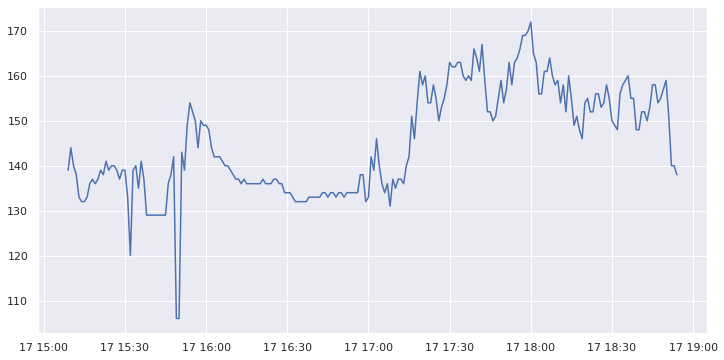

In [152]:
# plot time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Lifetouch Heart Rate'])
plt.show()


In [153]:
df['Lifetouch Heart Rate_diff'] = df[['Lifetouch Heart Rate']].diff(axis = 0,periods = 1)
df.head()

,Lifetouch Heart Rate,Lifetouch Heart Rate_diff
Timestamp (GMT),,
2015-08-17 15:09:00,139.0,NaN
2015-08-17 15:10:00,144.0,5.0
2015-08-17 15:11:00,140.0,-4.0
2015-08-17 15:12:00,138.0,-2.0
2015-08-17 15:13:00,133.0,-5.0


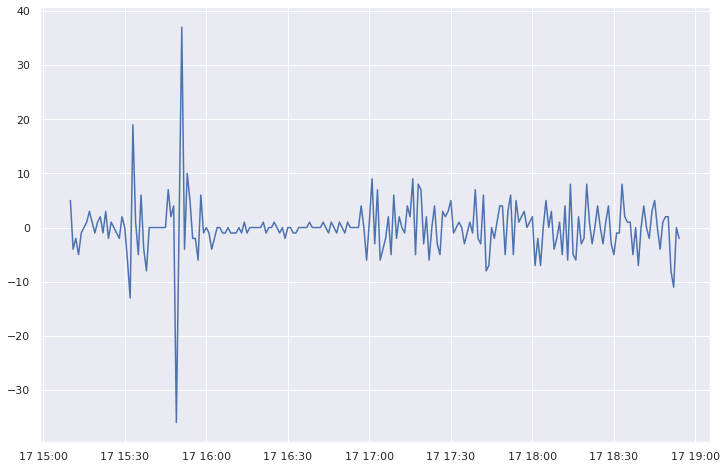

In [154]:
plt.figure(figsize =(12,8))
plt.plot(df.index,df['Lifetouch Heart Rate_diff'])
plt.show()

##Plot the time series##

In [155]:
df = df.bfill()

Check stationarity of the series

In [156]:
df.head()

,Lifetouch Heart Rate,Lifetouch Heart Rate_diff
Timestamp (GMT),,
2015-08-17 15:09:00,139.0,5.0
2015-08-17 15:10:00,144.0,5.0
2015-08-17 15:11:00,140.0,-4.0
2015-08-17 15:12:00,138.0,-2.0
2015-08-17 15:13:00,133.0,-5.0


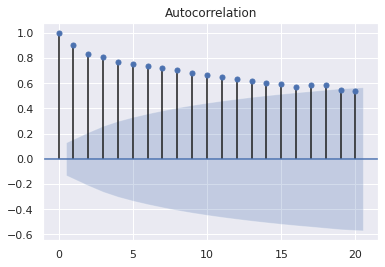

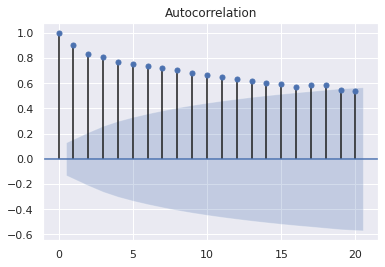

In [157]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Lifetouch Heart Rate'], lags=20)


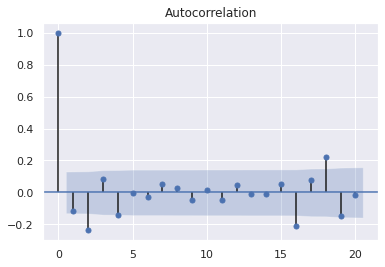

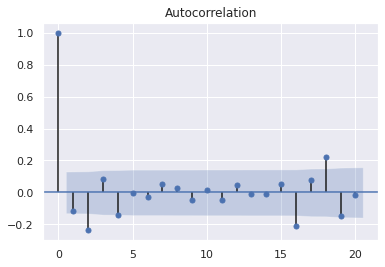

In [158]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Lifetouch Heart Rate_diff'], lags=20)

In [159]:

# ADF test on random numbers
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

series = df.loc[:, 'Lifetouch Heart Rate_diff'].values
adf_test(series)

ADF Statistic: -8.378736496602256
p-value: 2.5440013768441153e-13
Critial Values:
   1%, -3.4604283689894815
Critial Values:
   5%, -2.874768966942149
Critial Values:
   10%, -2.57382076446281


In [160]:
# df_diff = np.diff(df['Lifetouch Heart Rate'])
#we have done differencing now test for stationarity below

In [161]:
##adf_test(df_diff)

#ARIMA Model#

In [162]:
p = d = q = range(0, 3)

# generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq = [(1, 1, 1, 12)]

for param in pdq:
    for param_seasonal in seasonal_pdq:
          mod = sm.tsa.statespace.SARIMAX(df['Lifetouch Heart Rate'],
                                          order=param,
                                          seasonal_order=param_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

          mod_fit = mod.fit()

          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, mod_fit.aic))

ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1480.9732424490617
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1341.2409592923052
ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:1308.228177767666
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1249.8661831622462
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1242.4090525963898
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:1221.926847830975
ARIMA(0, 2, 0)x(1, 1, 1, 12)12 - AIC:1400.886973768338
ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:1244.7950716018295
ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:1238.318816433703
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1247.512321803346
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1243.4062085949804
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:1227.8053719175075
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1250.1044631880231
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1233.161124759007
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:1223.0873294783296
ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:1360.0466964528564
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:1245.543092367131
ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:1239.3404767210334

In [163]:
# # specify model
# model = sm.tsa.statespace.SARIMAX(df['Lifetouch Heart Rate'],
#                                 order=(0, 1, 2),
#                                 seasonal_order=(1, 1, 1, 12),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)
# # train model
# model_fit = model.fit()

# # make predictions
# preds = model_fit.predict(start=pd.to_datetime('2015-08-17 15:09:00'), dynamic=False)

# # calculate MSE
# actuals = df['Lifetouch Heart Rate']
# print(f'Mean Squared Error: {round(mean_squared_error(actuals, preds), 2)}')

In [164]:
train=df.iloc[:-20]
test=df.iloc[-20:]
model=sm.tsa.statespace.SARIMAX(df['Lifetouch Heart Rate'],order=(0,1,2),seasonal_order=(1,1,1,12),enforce_invertibility=False).fit()

start=len(train)
end=len(train)+len(test)-1

predictions=model.predict(start=start,end=end,params=model.params)

mse=mean_squared_error(test['Lifetouch Heart Rate'],predictions)
print("Root Mean Squared Error:",np.sqrt(mse))

mae=mean_absolute_error(test['Lifetouch Heart Rate'],predictions)
print('Mean Absolute Error',mae)

Root Mean Squared Error: 4.534066038329563
Mean Absolute Error 3.4040627782122512


In [165]:
forecasts=model.forecast(steps=20)
print(forecasts)

2015-08-17 18:55:00    139.980190
2015-08-17 18:56:00    141.778557
2015-08-17 18:57:00    144.247966
2015-08-17 18:58:00    144.341668
2015-08-17 18:59:00    143.253916
2015-08-17 19:00:00    144.759386
2015-08-17 19:01:00    142.581036
2015-08-17 19:02:00    142.011224
2015-08-17 19:03:00    142.260741
2015-08-17 19:04:00    141.499265
2015-08-17 19:05:00    141.774207
2015-08-17 19:06:00    142.397329
2015-08-17 19:07:00    142.081536
2015-08-17 19:08:00    141.483076
2015-08-17 19:09:00    143.938403
2015-08-17 19:10:00    144.032626
2015-08-17 19:11:00    142.961081
2015-08-17 19:12:00    144.469364
2015-08-17 19:13:00    142.267761
2015-08-17 19:14:00    141.683648
Freq: T, Name: predicted_mean, dtype: float64


Text(0.5, 1.0, 'Forcasts\xa0and\xa0Initial\xa0Values\xa0Plot')

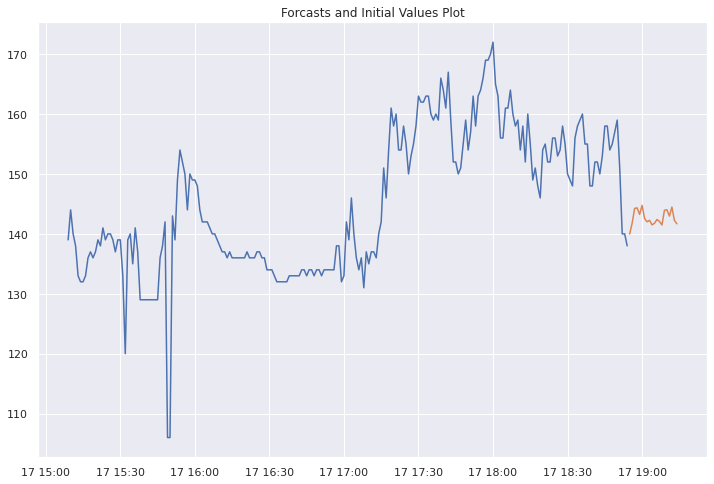

In [166]:
plt.figure(figsize=(12,8))
plt.plot(df['Lifetouch Heart Rate'],label='Forecasts')
plt.plot(forecasts)
plt.title("Forcasts and Initial Values Plot")

**SARIMA** **MODEL**

In [184]:
df['Lifetouch Heart Rate']

Timestamp (GMT)
2015-08-17 15:09:00    139.0
2015-08-17 15:10:00    144.0
2015-08-17 15:11:00    140.0
2015-08-17 15:12:00    138.0
2015-08-17 15:13:00    133.0
                       ...  
2015-08-17 18:50:00    159.0
2015-08-17 18:51:00    151.0
2015-08-17 18:52:00    140.0
2015-08-17 18:53:00    140.0
2015-08-17 18:54:00    138.0
Name: Lifetouch Heart Rate, Length: 226, dtype: float64

In [192]:

# order - The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters.
# seasonal_order - The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.
model = sm.tsa.statespace.SARIMAX(df['Lifetouch Heart Rate'],
                                  order=(0, 1, 2),
                                 
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
# train model
model_fit = model.fit()
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:     Lifetouch Heart Rate   No. Observations:                  226
Model:                 SARIMAX(0, 1, 2)   Log Likelihood                -664.777
Date:                  Sun, 19 Feb 2023   AIC                           1335.555
Time:                          17:29:42   BIC                           1345.763
Sample:                      08-17-2015   HQIC                          1339.676
                           - 08-17-2015                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1373      0.057     -2.427      0.015      -0.248      -0.026
ma.L2         -0.3789      0.030    -12.782      0.000      -0.437      -0.321
sigma2        23.3397      1.045    

In [193]:
  df.tail()

,Lifetouch Heart Rate
Timestamp (GMT),
2015-08-17 18:50:00,159.0
2015-08-17 18:51:00,151.0
2015-08-17 18:52:00,140.0
2015-08-17 18:53:00,140.0
2015-08-17 18:54:00,138.0


In [194]:
# make predictions
preds = model_fit.predict(start=pd.to_datetime('2015-08-17 18:20:00'), dynamic=False)
print(preds)

2015-08-17 18:20:00    148.169118
2015-08-17 18:21:00    154.356520
2015-08-17 18:22:00    152.702449
2015-08-17 18:23:00    151.852648
2015-08-17 18:24:00    152.245911
2015-08-17 18:25:00    155.428721
2015-08-17 18:26:00    154.499216
2015-08-17 18:27:00    152.989402
2015-08-17 18:28:00    154.429263
2015-08-17 18:29:00    157.126830
2015-08-17 18:30:00    153.939144
2015-08-17 18:31:00    151.346670
2015-08-17 18:32:00    150.814665
2015-08-17 18:33:00    149.275568
2015-08-17 18:34:00    156.143129
2015-08-17 18:35:00    155.197299
2015-08-17 18:36:00    157.774346
2015-08-17 18:37:00    158.253646
2015-08-17 18:38:00    154.603484
2015-08-17 18:39:00    156.178295
2015-08-17 18:40:00    148.972678
2015-08-17 18:41:00    151.232137
2015-08-17 18:42:00    152.263097
2015-08-17 18:43:00    151.745197
2015-08-17 18:44:00    150.339304
2015-08-17 18:45:00    153.295895
2015-08-17 18:46:00    156.346027
2015-08-17 18:47:00    155.990617
2015-08-17 18:48:00    153.646663
2015-08-17 18:

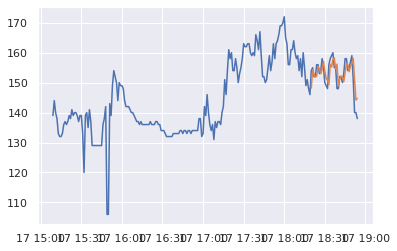

In [195]:
plt.plot(df)
plt.plot(preds)

In [197]:
# Out-of-sample forecasts
forecasts = model_fit.forecast(steps=20)
print(forecasts)

2015-08-17 18:55:00    140.509577
2015-08-17 18:56:00    143.056523
2015-08-17 18:57:00    143.056523
2015-08-17 18:58:00    143.056523
2015-08-17 18:59:00    143.056523
2015-08-17 19:00:00    143.056523
2015-08-17 19:01:00    143.056523
2015-08-17 19:02:00    143.056523
2015-08-17 19:03:00    143.056523
2015-08-17 19:04:00    143.056523
2015-08-17 19:05:00    143.056523
2015-08-17 19:06:00    143.056523
2015-08-17 19:07:00    143.056523
2015-08-17 19:08:00    143.056523
2015-08-17 19:09:00    143.056523
2015-08-17 19:10:00    143.056523
2015-08-17 19:11:00    143.056523
2015-08-17 19:12:00    143.056523
2015-08-17 19:13:00    143.056523
2015-08-17 19:14:00    143.056523
Freq: T, Name: predicted_mean, dtype: float64


In [202]:
#actuals 
actuals = df['Lifetouch Heart Rate'][-35:]



mse=mean_squared_error (actuals,preds)
print("Root Mean Squared Error:",np.sqrt(mse))

mae=mean_absolute_error(actuals,preds)
print('Mean Absolute Error',mae)


Root Mean Squared Error: 3.8879911490432093
Mean Absolute Error 2.9882813498108827


In [203]:
import json

predictions = forecasts

data = []
for pred in predictions:
    data.append({'prediction': pred})

print(data[0:5])

submission_file_path = "submission.json"
with open(submission_file_path, 'w') as fp:
    fp.write('\n'.join(json.dumps(i) for i in data))


[{'prediction': 140.5095772617904}, {'prediction': 143.0565228476444}, {'prediction': 143.0565228476444}, {'prediction': 143.0565228476444}, {'prediction': 143.0565228476444}]


#Exponential smoothing

In [172]:
df=df.drop('Lifetouch Heart Rate_diff',axis=1)

In [173]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [174]:
# Split the data into training and test sets
train_data = df[:-20]
test_data = df[-20:]

# Fit a simple exponential smoothing model to the training data
model = SimpleExpSmoothing(train_data['Lifetouch Heart Rate']).fit(smoothing_level=0.2)



In [175]:
test_data

,Lifetouch Heart Rate
Timestamp (GMT),
2015-08-17 18:35:00,159.0
2015-08-17 18:36:00,160.0
2015-08-17 18:37:00,155.0
2015-08-17 18:38:00,155.0
2015-08-17 18:39:00,148.0
2015-08-17 18:40:00,148.0
2015-08-17 18:41:00,152.0
2015-08-17 18:42:00,152.0
2015-08-17 18:43:00,150.0


In [176]:
# Use the fitted model to make predictions for the test data
# predictions = model.predict(100)
# predictions = model.predict(start=len(test_data), end=len(test_data))
predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Calculate the MAE and RMSE of the predictions
mae = mean_absolute_error(test_data, predictions)
rmse = mean_squared_error(test_data, predictions, squared=False)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 4.90, RMSE: 6.58


In [177]:
predictions

2015-08-17 18:35:00    153.728246
2015-08-17 18:36:00    153.728246
2015-08-17 18:37:00    153.728246
2015-08-17 18:38:00    153.728246
2015-08-17 18:39:00    153.728246
2015-08-17 18:40:00    153.728246
2015-08-17 18:41:00    153.728246
2015-08-17 18:42:00    153.728246
2015-08-17 18:43:00    153.728246
2015-08-17 18:44:00    153.728246
2015-08-17 18:45:00    153.728246
2015-08-17 18:46:00    153.728246
2015-08-17 18:47:00    153.728246
2015-08-17 18:48:00    153.728246
2015-08-17 18:49:00    153.728246
2015-08-17 18:50:00    153.728246
2015-08-17 18:51:00    153.728246
2015-08-17 18:52:00    153.728246
2015-08-17 18:53:00    153.728246
2015-08-17 18:54:00    153.728246
Freq: T, dtype: float64

In [212]:
# single exponential smoothing
single_fit = SimpleExpSmoothing(train_data).fit()
single_predictions = single_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

In [213]:
# double exponential smoothing
double_fit = Holt(df["Lifetouch Heart Rate"]).fit()
double_predictions = double_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)


In [214]:
# triple exponential smoothing
tripple_fit = ExponentialSmoothing(df["Lifetouch Heart Rate"], trend="mul",seasonal="mul", seasonal_periods=12).fit()
triple_predictions = tripple_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

In [215]:
print(single_predictions)

2015-08-17 18:35:00    156.835231
2015-08-17 18:36:00    156.835231
2015-08-17 18:37:00    156.835231
2015-08-17 18:38:00    156.835231
2015-08-17 18:39:00    156.835231
2015-08-17 18:40:00    156.835231
2015-08-17 18:41:00    156.835231
2015-08-17 18:42:00    156.835231
2015-08-17 18:43:00    156.835231
2015-08-17 18:44:00    156.835231
2015-08-17 18:45:00    156.835231
2015-08-17 18:46:00    156.835231
2015-08-17 18:47:00    156.835231
2015-08-17 18:48:00    156.835231
2015-08-17 18:49:00    156.835231
2015-08-17 18:50:00    156.835231
2015-08-17 18:51:00    156.835231
2015-08-17 18:52:00    156.835231
2015-08-17 18:53:00    156.835231
2015-08-17 18:54:00    156.835231
Freq: T, dtype: float64


In [216]:
print(double_predictions)

2015-08-17 18:35:00    157.135677
2015-08-17 18:36:00    158.568208
2015-08-17 18:37:00    159.667067
2015-08-17 18:38:00    156.061022
2015-08-17 18:39:00    155.236824
2015-08-17 18:40:00    149.648363
2015-08-17 18:41:00    148.371064
2015-08-17 18:42:00    151.164885
2015-08-17 18:43:00    151.803441
2015-08-17 18:44:00    150.406509
2015-08-17 18:45:00    152.401547
2015-08-17 18:46:00    156.714734
2015-08-17 18:47:00    157.700557
2015-08-17 18:48:00    154.840116
2015-08-17 18:49:00    154.957773
2015-08-17 18:50:00    156.527545
2015-08-17 18:51:00    158.429213
2015-08-17 18:52:00    152.692337
2015-08-17 18:53:00    142.895274
2015-08-17 18:54:00    140.656055
Freq: T, dtype: float64


In [217]:
print(triple_predictions)

2015-08-17 18:35:00    156.332440
2015-08-17 18:36:00    159.939883
2015-08-17 18:37:00    157.086533
2015-08-17 18:38:00    154.582873
2015-08-17 18:39:00    155.802120
2015-08-17 18:40:00    149.214889
2015-08-17 18:41:00    148.580254
2015-08-17 18:42:00    152.329123
2015-08-17 18:43:00    151.507382
2015-08-17 18:44:00    149.083407
2015-08-17 18:45:00    154.400799
2015-08-17 18:46:00    157.603258
2015-08-17 18:47:00    156.827349
2015-08-17 18:48:00    156.017368
2015-08-17 18:49:00    152.391645
2015-08-17 18:50:00    155.222370
2015-08-17 18:51:00    159.139955
2015-08-17 18:52:00    152.275849
2015-08-17 18:53:00    142.809295
2015-08-17 18:54:00    141.519176
Freq: T, dtype: float64


In [219]:
# Calculate the MAE and RMSE of the predictions
mae = mean_absolute_error(test_data, single_predictions)
rmse = mean_squared_error(test_data, single_predictions, squared=False)

print(f"Single_fit Predictions MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 5.73, RMSE: 7.94


In [220]:
# Calculate the MAE and RMSE of the predictions
mae = mean_absolute_error(test_data, double_predictions)
rmse = mean_squared_error(test_data, double_predictions, squared=False)

print(f"Double_fit Predictions MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Double_fit Predictions MAE: 3.39, RMSE: 4.45


In [221]:
# Calculate the MAE and RMSE of the predictions
mae = mean_absolute_error(test_data, triple_predictions)
rmse = mean_squared_error(test_data, triple_predictions, squared=False)

print(f"Triple_fit Predictions MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Triple_fit Predictions MAE: 3.32, RMSE: 4.46
